In [96]:
import pandas as pd
import unicodedata
import string
import re
import numpy as np
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from statistics import mean
plt.style.use('ggplot')


## Data Pipeline
The code below shows the following steps:
1. Importing the data from .txt files
1. Splitting the data into title, date, text as well as type of speech
1. Splitting speech transcripts by speaker
1. Scraping additional debates from Debates.org & splitting them by speaker

In [97]:
### Creates initial dataframe from .txt files
parties = ['republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'republican', 'republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'democrat']
pres = ['bush', 'carter', 'clinton', 'eisenhower', 'fdroosevelt', 'ford', 'gwbush', 'hoover', 'kennedy', 'lbjohnson', 'nixon', 'obama', 'reagan', 'truman']
war = ['war', 'nw', 'nw', 'nw', 'war', 'nw', 'war', 'nw', 'war', 'war', 'war', 'war', 'nw', 'war']
pres_dict = {}
for i, v in enumerate(pres):
    pres_dict[v]= {}
    pres_dict[v]['party'] = parties[i]

## imports .txt files and puts them into a dictionary
import os
data = []
for i, p in enumerate(pres):
    folder = 'corpus/' + p + '/'
    for filename in os.listdir(folder): 
        indiv = []
        indiv.append(p)
        indiv.append(parties[i])
        indiv.append(war[i])
        path = folder + filename
        if os.path.isfile(path) and filename.endswith(".txt"): 
            with open(path, "r") as file: 
                indiv.append(file.read())
            data.append(indiv)

df = pd.DataFrame (data, columns = ['name', 'party', 'war','speech'])

### splits the speech into title, date, text
def get_text(x):
    idx = x.find('>', x.find('>')+1, 100)
    return x[idx+1:]

df['title'] = df['speech'].apply(lambda x: x.split('"')[1])
df['date'] = df['speech'].apply(lambda x: x.split('"')[3])
df['text'] = df['speech'].apply(get_text)


### Classifies speeches as interview, debate, inaugural address, state of the union or press conference
def is_speech_type(string, speech_type):
    if string.lower().find(speech_type)>=0:
        return True
    else:
        return False


speech_type = ['interview', 'debate', 'inaugural address', 'state of the union', 'press conference']
for i in speech_type:
    df[i] = df.title.apply(lambda x: is_speech_type(x, i))

## Use this function to find parts of the debates that belong to each speaker
def find_between( s, first, last ):
    result = ''
    while True:
        try:
            start = s.index(first) + len(first)
            end = s.index( last, start )
            result += s[start:end] + ' '
            s = s[end:]
        except ValueError:
            return result

In [10]:
trump = np.loadtxt('corpus/trump_speech/trump.txt')

ValueError: could not convert string to float: 'SPEECH'

In [15]:
trump_speeches = string.split("SPEECH")

AttributeError: module 'string' has no attribute 'split'

In [698]:
len(trump_speeches)

12

In [51]:
df.head()

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False,False
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False,False
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False,False


In [52]:
df[df['debate']==True]

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
5,bush,republican,war,"<title=""Debate with Bill Clinton and Ross Pero...",Debate with Bill Clinton and Ross Perot,"October 11, 1992","\n\n<Jim Lehrer. Good evening, and welcome to ...",False,True,False,False,False
13,bush,republican,war,"<title=""Debate with Michael Dukakis"">\n<date=""...",Debate with Michael Dukakis,"September 25, 1988",\n\n<BUSH:> I think we've seen a deterioration...,False,True,False,False,False
23,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 6, 1976",\n\n<Good evening. I am Pauline Frederick of N...,False,True,False,False,False
26,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 22, 1976","\n\n<Good evening, I am Barbara Walters, moder...",False,True,False,False,False
28,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"September 23, 1976","\n\n<I am Edwin Newman, moderator of this firs...",False,True,False,False,False
41,carter,democrat,nw,"<title=""Debate with Ronald Reagan"">\n<date=""Oc...",Debate with Ronald Reagan,"October 28, 1980",\n\n<MR. SMITH. The League of Women Voters is ...,False,True,False,False,False
60,clinton,democrat,nw,"<title=""Presidential Debate with Senator Bob D...",Presidential Debate with Senator Bob Dole,"October 6, 1996",\n\n<JIM LEHRER: Good evening from the Bushnel...,False,True,False,False,False
252,kennedy,democrat,war,"<title=""Debate with Richard Nixon in Washingto...","Debate with Richard Nixon in Washington, D. C.","October 7, 1960","\n\n<FRANK McGEE, MODERATOR: Good evening. Thi...",False,True,False,False,False
253,kennedy,democrat,war,"<title=""Debate with Richard Nixon in New York ...",Debate with Richard Nixon in New York and Los ...,"October 13, 1960","\n\n<BILL SHADEL, MODERATOR: Good evening. I'm...",False,True,False,False,False
260,kennedy,democrat,war,"<title=""Debate with Richard Nixon in New York""...",Debate with Richard Nixon in New York,"October 21, 1960","\n\n<QUINCY HOWE, MODERATOR: I am Quincy Howe ...",False,True,False,False,False


In [98]:
### Splits existing debate transcripts by speaker
idx = [5 ,13, 23, 26, 28, 41,60, 252, 253, 260, 265, 449, 453]
opponent = [['clinton', 'democrat'], ['dukakis', 'democrat'], ['ford', 'republican'], ['ford', 'republican'],
            ['ford', 'republican'], ['reagan', 'republican'], ['dole', 'republican'], ['nixon', 'republican'], ['nixon', 'republican'],
            ['nixon', 'republican'], ['nixon', 'republican'], ['mondale','democrat'], ['mondale','democrat']]
        
delimiters = [['Bush.>', '>', '<Governor Clinton.', '>'], ['BUSH:>', '<', '<DUKAKIS:','>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'],['THE PRESIDENT.>', '<', '<GOVERNOR REAGAN.', '>'],
             ['<PRESIDENT CLINTON:>', '<', '<SENATOR DOLE:', '<'],['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'],
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], 
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<The President.>', '<', '<Mr. Mondale.', '>'],
              ['<PRESIDENT REAGAN:>', '<', '<MR. MONDALE:', '>']]
opponents = []
for i in range(len(idx)):
    text = df.loc[idx[i], 'text']
    df.loc[idx[i],'text'] = find_between(df.loc[idx[i],'text'], delimiters[i][0], delimiters[i][1])
    opponent_text = find_between(text, delimiters[i][2], delimiters[i][3])
    #print(f'for {idx[i]}, delimited opponent {opponent[i]} between {delimiters[i][2]} and {delimiters[i][3]}')
    opponents.append(opponent[i] + [0, 0, 0, 0] + [opponent_text] + [False, True, False, False, False])
opponents = pd.DataFrame(data = opponents, columns = df.columns)
df = pd.concat([df, opponents])

In [99]:
### scrapes debate transcripts from Debates.org and splits by speaker
import pprint
# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

url = 'https://www.debates.org/voter-education/debate-transcripts/'
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

classes = []
class_num = [i for i in range(100, 141)]
for v in [138, 139, 133, 140, 135, 136, 137, 134, 130, 132, 129, 127, 121, 122, 118, 101]:
    class_num.remove(v)

for i in class_num:
    classes.append("page_item page-item-"+str(i))

debate_names = [['kaine', 'democrat', 'pence', 'republican'], ['obama', 'democrat', 'romney', 'republican'],
                ['obama', 'democrat', 'romney', 'republican'], ['biden', 'democrat', 'ryan', 'republican'],
               ['obama', 'democrat', 'romney', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['biden', 'democrat', 'palin', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['mccain', 'republican', 'obama', 'democrat'], ['bush', 'republican', 'kerry', 'democrat'],
               ['bush','republican','kerry','democrat'], ['cheney', 'republican', 'edwards', 'democrat'],
               ['bush', 'republican', 'kerry', 'democrat'], ['gore', 'democrat', 'bush', 'republican'],
                ['lieberman', 'democrat', 'cheney', 'republican'], ['gore', 'democrat', 'bush', 'republican'],
                ['gore', 'democrat', 'bush', 'republican'], ['gore', 'democrat', 'kemp', 'republican'],
                ['clinton', 'democrat', 'dole', 'republican'], ['gore', 'democrat', 'quayle', 'republican'],
                ['clinton', 'democrat', 'bush', 'republican'], ['clinton', 'democrat', 'bush', 'republican'],
                ['bush', 'republican', 'dukakis', 'democrat'], ['bentsen', 'democrat', 'quayle', 'republican'],
                ['bush', 'republican','ferraro', 'democrat']]

### Gets text from each speech
links = []
for i in classes:
    x = soup.find_all(class_= i)
    links.append('http://debates.org/'+ str(x).split('"')[3])


results = []
for i, link in enumerate(links):
    req = requests.get(link)
    soup_link = BeautifulSoup(req.content, 'html.parser')
    text = soup_link.get_text()
    text = text.lower()
    for v in [0, 2]:
        text_1 = find_between(text, '\n'+debate_names[i][v]+":", ':')
        results.append([debate_names[i][v], debate_names[i][v+1]] + [0, 0, 0, 0] + [text_1] + [False, True, False, False, False])
for i in [18, 20, 24, 27, 31, 33]:
     results[i][0]=results[i][0].replace("bush", "gwbush")
more_debates = pd.DataFrame(data = results, columns = df.columns)
df = pd.concat([df, more_debates])


In [ ]:
## I loaded Trump's speeches to use as a test set later on.

In [720]:
politico = 'https://www.politico.com/story/2016/07/full-transcript-donald-trump-nomination-acceptance-speech-at-rnc-225974'

In [721]:
req = requests.get(politico)
soup_link = BeautifulSoup(req.content, 'html.parser')
text = soup_link.get_text()
text = text.lower()

In [734]:
speech= text.split("politico thursday afternoon")

In [743]:
trump_speeches.append(speech[2].split("follow @ politico")[0])

In [24]:
df = df.reset_index()

In [635]:
df.index

RangeIndex(start=0, stop=549, step=1)

## EDA!

In [25]:
df.head()

,index,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
0,0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False
1,1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False,False
2,2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False
3,3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False,False
4,4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False,False


In [636]:
df.count()

index                 549
name                  549
party                 549
war                   549
speech                549
title                 549
date                  549
text                  549
interview             549
debate                549
inaugural address     549
state of the union    549
press conference      549
dtype: int64

The 549 texts included 16 Democrats (7 presidents, 9 debate candidates) and 15 Republicans (7 presidents, 8 debate candidates).

In [637]:
print('Speeches by president')
print(df.name.value_counts())
print('')
print('speeches by party')
print(df.party.value_counts())

Speeches by president
lbjohnson      71
reagan         60
obama          54
fdroosevelt    49
kennedy        45
gwbush         45
clinton        43
hoover         29
bush           27
nixon          27
carter         22
truman         19
ford           17
eisenhower      6
gore            5
kerry           3
romney          3
mccain          3
biden           2
quayle          2
cheney          2
dole            2
dukakis         2
mondale         2
ryan            1
kemp            1
bentsen         1
palin           1
pence           1
kaine           1
ferraro         1
lieberman       1
edwards         1
Name: name, dtype: int64

speeches by party
democrat      322
republican    227
Name: party, dtype: int64


Speeches by speaker

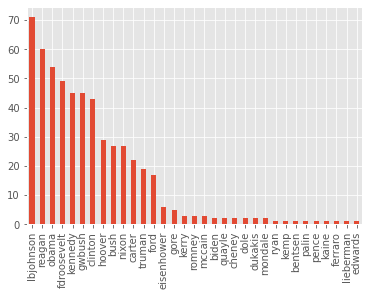

In [638]:
df['name'].value_counts().plot(kind='bar')

LBJ had the most speeches, which lead me to wonder if these were disproportionately press conferences due to the Vietnam War.  It turns out that yes, he had the most press conferences in the corpus, 23 in total.

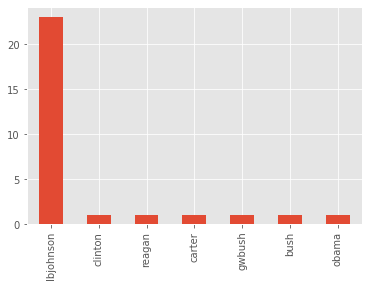

In [639]:
df[df['press conference']== True]['name'].value_counts().plot(kind='bar')

The table below shows the breakdown of speech type by speaker.

In [640]:
df.groupby('name').sum()

,index,interview,debate,inaugural address,state of the union,press conference
name,,,,,,
bentsen,46,0.0,1.0,0.0,0.0,0.0
biden,18,0.0,2.0,0.0,0.0,0.0
bush,429,0.0,6.0,1.0,3.0,1.0
carter,737,0.0,4.0,1.0,3.0,1.0
cheney,51,0.0,2.0,0.0,0.0,0.0
clinton,2614,0.0,5.0,0.0,7.0,1.0
dole,43,0.0,2.0,0.0,0.0,0.0
dukakis,46,0.0,2.0,0.0,0.0,0.0
edwards,23,0.0,1.0,0.0,0.0,0.0


In [101]:
df['text length'] = df.text.apply(lambda x: len(x.split(' ')))

The median speech length was 3,176 words, which assuming 150 words/minute means 21.17 minutes.

In [643]:
df['text length'].median()/150

21.173333333333332

In [644]:
df[df['party'] == 'democrat']['text length'].sum()

1118719

In [645]:
df[df['party'] == 'republican']['text length'].sum()

790496

In [104]:
df.sort_values(by='text length', ascending=True)

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length
45,dukakis,democrat,0,0,0,0,,False,True,False,False,False,1
120,fdroosevelt,democrat,war,"<title=""Message to Congress Requesting War Dec...",Message to Congress Requesting War Declaration...,"December 11, 1941","<title=""Message to Congress Requesting War Dec...",False,False,False,False,False,144
202,hoover,republican,nw,"<title=""Message Regarding “Black Thursday”"">\n...",Message Regarding “Black Thursday”,"October 25, 1929",\n<IN REPLY to press questions as to the busin...,False,False,False,False,False,204
307,lbjohnson,democrat,war,"<title=""Statement on Sending Troops to the Dom...",Statement on Sending Troops to the Dominican R...,"April 28, 1965",\nI have just concluded a meeting with the lea...,False,False,False,False,False,241
355,nixon,republican,war,"<title=""Remarks Announcing an Agreement on Str...",Remarks Announcing an Agreement on Strategic A...,"May 20, 1971","\nGood afternoon, ladies and gentlemen:\nAs yo...",False,False,False,False,False,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,hoover,republican,nw,"<title=""First State of the Union Address"">\n<d...",First State of the Union Address,"December 3, 1929",\nTo the Senate and House of Representatives:\...,False,False,False,True,False,10830
8,bush,republican,war,"<title=""Press Conference with Mikhail Gorbache...",Press Conference with Mikhail Gorbachev,"July 31, 1991","\n\n<President Gorbachev. Good evening, ladies...",False,False,False,False,True,11902
10,mccain,republican,0,0,0,0,"well, thank you, jim. and thanks to everybody...",False,True,False,False,False,12353
11,obama,democrat,0,0,0,0,"well, thank you very much, jim, and thanks to...",False,True,False,False,False,13229


The shortest text was FDR's declaration of war on Germany and Italy.

In [647]:
df.iloc[120].text

'<title="Message to Congress Requesting War Declarations with Germany and Italy">\n<date="December 11, 1941">\nTo the Congress:\nOn the morning of December eleventh, the Government of Germany, pursuing its course of world conquest, declared war against the United States.\nThe long known and the long expected has thus taken place. The forces endeavoring to enslave the entire world now are moving toward this hemisphere.\nNever before has there been a greater challenge to life, liberty, and civilization.\nDelay invites greater danger. Rapid and united effort by all of the peoples of the world who are determined to remain free will insure a world victory of the forces of justice and of righteousness over the forces of savagery and of barbarism.\nItaly also has declared war against the United States.\nI therefore request the Congress to recognize a state of war between the United States and Germany, and between the United States and Italy.\n'

In [648]:
vocab = set()
total = []
df['text'].str.lower().str.split().apply(vocab.update)
df['text'].str.lower().str.split().apply(total.append)
total = [item for sublist in total for item in sublist]
print(f'The vocabulary of the corpus is {len(vocab)} unique words & {len(total)} total words.')

The vocabulary of the corpus is 57629 unique words & 1928737 total words.


Text(0.5, 1.0, 'Word Count by Party')

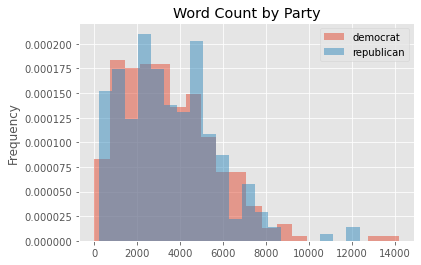

In [650]:
fig, ax = plt.subplots()
df[df['party'] == 'democrat']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'democrat')
df[df['party'] == 'republican']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'republican')
ax.legend()
ax.set_title('Word Count by Party')

In [102]:
df[df['text length']==0]

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length


# Testing and Feature Engineering

This section includes:
1. The initial Multinomial Bayes Model and the feature engineering used in optimization
1. The Multinomial Naive Bayes Model used to predict whether a text is from a Democrat or a Republican
1. The top tri-grams unique to each party (by log probability)
1. The optimized Random Forest Classifier that ultimately was not used

In [27]:
sw = stopwords.words('english')

new_sw = ['also', '000', 'see', 'come', 'day','say', 'us', 'well', 'le', "'m", 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'cannot', 'two', 'long', 'said', 'like', 'years', 'think','would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)



In [ ]:
## returns the top features for dems republications (by log probability), as well as the features that are unique to 
#each party in the top num_features
def get_top_features(feature_logs, labels, num_features):
    zero_all = np.array(labels)[np.argsort(feature_logs[0])[-1*num_features:]]
    one_all = np.array(labels)[np.argsort(feature_logs[1])[-1*num_features:]]
    zero_unique = [x for x in zero_all if x not in one_all]
    one_unique = [x for x in one_all if x not in zero_all]
    return zero_all, one_all, zero_unique, one_unique


In [58]:
## Initial model has 25% recall for republicans and a cross validation score of .66
## Naive Bayes Model
def run_model_initial(X, y, max_feat = 200, stop_words = sw):
    tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = max_feat)
    X = tfidf.fit_transform(X)
    labels = tfidf.get_feature_names()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 5)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, cvs, X_test, y_test, labels, X, tfidf
    
clf, cvs, X_test, y_test, labels, X, tfidf = run_model_initial(df.text, df.party, stop_words = sw)

td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')
print(f'Cross-validation score: {cvs}')

zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(" ")
print(f'Dem unique: {zero_unique}')
print(f'Rep unique: {one_unique}')

True Dems: 79, False Republicans: 2, False Dems: 43, True Republicans: 14
Recall for Democrats: 0.9753086419753086
Recall for Republicans: 0.24561403508771928
Cross-validation score: 0.6594475462826918
 
Dem unique: ['vietnam', 'back', 'take', 'south', 'still', 'power', 'much', 'even', 'go', 'hope', 'children']
Rep unique: ['state', 'together', 'system', 'nuclear', 'thank', 'union', 'senator', 'economic', 'iraq', 'federal', 'soviet']


I looked at the tradeoff between accuracy and recall for each party, ultimately deciding to work within a range of 1000 to 1500 features

In [59]:
feat = np.arange(500, 10000, 250)
acc = []
recall_dems = []
recall_rep = []
for i in feat:
    clf, cvs, X_test, y_test, _, _, _ = run_model_initial(df.text, df.party, max_feat = i, stop_words = sw)
    td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    recall_d = td/(td + fr)
    recall_r = tr/(fd + tr)
    acc.append(cvs)
    recall_dems.append(recall_d)
    recall_rep.append(recall_r)


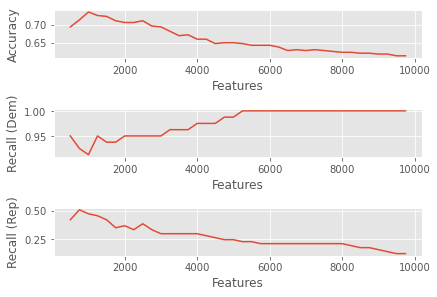

In [60]:
fig, ax = plt.subplots(3,1)

ax[0].plot(feat, acc)
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Accuracy')
ax[1].plot(feat, recall_dems)
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Recall (Dem)')
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[2].plot(feat, recall_rep)
ax[2].set_xlabel('Features')
ax[2].set_ylabel('Recall (Rep)')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

As the features grew, the model began to classify more people as Democrats.

The initial ROC curve showed an AUC of .870

In [66]:
clf, cvs, X_test, y_test, _, _, _ = run_model_initial(df.text, df.party, max_feat = 1500, stop_words = sw)

In [67]:
td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')

True Dems: 76, False Republicans: 5, False Dems: 33, True Republicans: 24
Recall for Democrats: 0.9382716049382716
Recall for Republicans: 0.42105263157894735


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.870


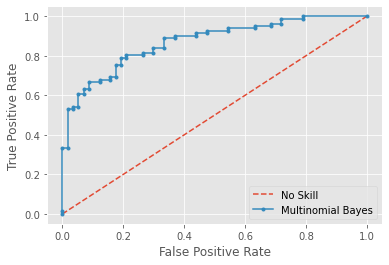

In [68]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# generate a no skill prediction (majority class)
y_test_coded = []
for i in y_test:
    if i == 'democrat':
        y_test_coded.append(1)
    else:
        y_test_coded.append(0)
    
    
ns_probs = [0 for _ in range(len(y_test))]
mnb_probs = clf.predict_proba(X_test)
# keep probabilities for being a republican only (column 1), democrat (column 0)
mnb_probs = mnb_probs[:, 0]
# calculate scores
ns_auc = roc_auc_score(y_test_coded, ns_probs)
mnb_auc = roc_auc_score(y_test_coded, mnb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (mnb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_coded, ns_probs)
mnb_fpr, mnb_tpr, _ = roc_curve(y_test_coded, mnb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(mnb_fpr, mnb_tpr, marker='.', label='Multinomial Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Credit for the ROC code goes to https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Next I graphed accuracy as a function of different thresholds

In [69]:
y_test_array = y_test.to_numpy()

Text(0, 0.5, 'Accuracy')

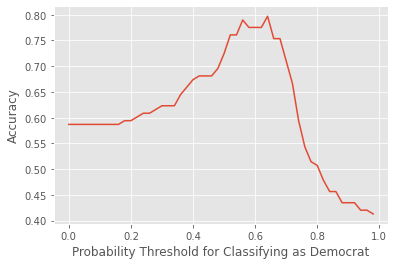

In [70]:
from statistics import mean
dem_prob = clf.predict_proba(X_test)[:,0]
thresh = np.arange(0,1, .02)
y_test
thresh_acc =[]

for t in thresh:
    correct = []
    for i,v in enumerate(dem_prob):
        if v >= t and y_test_array[i] =='democrat':
            correct.append(1)
        elif v<t and y_test_array[i] == 'republican':
            correct.append(1)
        else:
            correct.append(0)
    thresh_acc.append(mean(correct))

fig, ax = plt.subplots()
ax.plot(thresh, thresh_acc)
ax.set_xlabel('Probability Threshold for Classifying as Democrat')
ax.set_ylabel('Accuracy')
    

It appears that the optimal threshold is between .56 and .64; however, once I changed from 1-3grams to just trigrams in my model, I found that the best threshold was .54.

This is my main model with 1500 features, trigrams only, special stopwords, and a .54 threshold for classification as Democrat.

In [76]:
## Naive Bayes Model
def run_model(X, y, max_feat = 1500, stop_words = sw):
    tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (3,3), max_features = max_feat)
    X = tfidf.fit_transform(X)
    labels = tfidf.get_feature_names()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 5)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, cvs, X_test, y_test, labels, X, tfidf
    
clf, cvs, X_test, y_test, labels, X, tfidf = run_model(df.text, df.party, stop_words = sw)

True Dems: 75, False Republicans: 6, False Dems: 16, True Republicans: 41
Recall for Democrats: 0.9259259259259259
Recall for Republicans: 0.7192982456140351
Cross-validation score (using .5 threshold): 0.7931824860417278
 
Dem unique: ['health care reform', 'third world war', 'nuclear arms race', 'strength united states', 'executive branch government', 'voting rights act', 'president members congress', 'social security medicare', 'soldiers sailors marines', 'hundred million dollars', 'support american people', 'spread nuclear weapons', 'people back work', 'policy united states', 'north viet nam', 'government south vietnam', 'united states nation', 'world ever known', 'health care costs', 'chiang kai shek', 'god bless united', 'constitution united states', 'million new jobs', 'test ban treaty', 'general de gaulle', 'civil rights bill', 'united states government', 'bless united states', 'peace loving nations', 'people south vietnam', 'bless god bless', 'god bless god', 'martin luther ki

The confusion matrix is broken down below:

In [91]:
td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')
print(f'Cross-validation score (using .5 threshold): {cvs}')

True Dems: 75, False Republicans: 6, False Dems: 16, True Republicans: 41
Recall for Democrats: 0.9259259259259259
Recall for Republicans: 0.7192982456140351
Cross-validation score (using .5 threshold): 0.7931824860417278


In [75]:
### Evaluates accuracy using the .54 threshold
dem_prob = clf.predict_proba(X_test)[:,0]
correct = []
idx = list(y_test.index)
t = .54
print(y_test.shape)

y_test_array = y_test.to_numpy()
for i,v in enumerate(dem_prob):
    if v >= t and y_test_array[i] =='democrat':
        correct.append(1)
        df.loc[idx[i], 'accurate'] = True
    elif v<t and y_test_array[i] == 'republican':
        correct.append(1)
        df.loc[idx[i], 'accurate'] = True
    else:
        correct.append(0)
        df.loc[idx[i], 'accurate'] = False
print(f'Accuracy using threshold = {t}: {mean(correct)}')

(138,)
Accuracy using threshold = 0.54: 0.8695652173913043


In [747]:
trump = pd.Series(trump_speeches[0:11] + trump_speeches[13])

TypeError: can only concatenate list (not "str") to list

In [749]:
trump = trump.drop(12)

In [750]:
trump_vector = tfidf.fit_transform(trump)

In [751]:
print(clf.predict_proba(trump_vector)[:,0])

[0.5863747  0.51176675 0.46106733 0.67431799 0.71221315 0.54061495
 0.44888981 0.65072687 0.45917179 0.66780336 0.59354757 0.59632782
 0.44227937]


In [705]:
X_test.shape

(138, 9750)

## Random Forest

In [134]:
### fitted with grid search results
from sklearn.ensemble import RandomForestClassifier
overall_acc = []
# for i in range(10):
#     X_train, y_train, X_test, y_test = train_test_split(df.text, df.party, stratify = df.party, random_state = i)
#     rf = RandomForestClassifier()
#     rf = rf.fit(X_train, y_train)
#     acc = mean(cross_val_score(rf, X_train, y_train))
#     overall_acc.apend(acc)

# print(mean(overall_acc))

tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = 1500)
X = tfidf.fit_transform(df.text)
labels = tfidf.get_feature_names()
X_train, X_test, y_train, y_test = train_test_split(X, df.party, stratify = df.party, random_state = 5)
rf = RandomForestClassifier(n_estimators = 600, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt',
                           max_depth = 115, bootstrap = False)
rf = rf.fit(X_train, y_train)
acc = mean(cross_val_score(rf, X_train, y_train))

pred = rf.predict(X_test)
dem_prob_rf = rf.predict_proba(X_test)


The best threshold is [0.56]


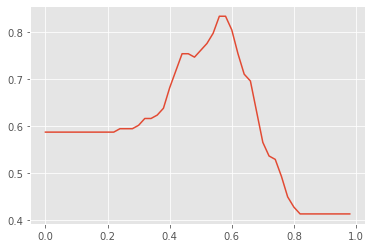

In [140]:
## Finding the best threshold for random forest
y_test_array = y_test.to_numpy()
dem_prob = rf.predict_proba(X_test)[:,0]
thresh = np.arange(0,1, .02)
thresh_acc =[]

for t in thresh:
    correct = []
    for i,v in enumerate(dem_prob):
        if v >= t and y_test_array[i] =='democrat':
            correct.append(1)
        elif v<t and y_test_array[i] == 'republican':
            correct.append(1)
        else:
            correct.append(0)

    thresh_acc.append(mean(correct))

fig, ax = plt.subplots()
ax.plot(thresh, thresh_acc)
print(f'The best threshold is {thresh[np.argsort(thresh_acc)[-1:]]}')

In [139]:
## Accuracy using .54 threshold
y_test_array = y_test.to_numpy()
correct = []
t = .56
for i,v in enumerate(dem_prob_rf[:, 0]):
    if v >= t and y_test_array[i] =='democrat':
        correct.append(1)
    elif v<t and y_test_array[i] == 'republican':
        correct.append(1)
    else:
        correct.append(0)
print(f'Accuracy: {mean(correct)}')

Accuracy: 0.8333333333333334


In [137]:
important = rf.feature_importances_
idx = np.argsort(important)[-20:]

np.array(labels)[idx]

array(['country', 'inflation', 'workers', 'still', 'afghanistan', 'south',
       'previous', 'terrorists', 'give', 'reduction', 'terrorist', 'stop',
       'college', 'soviet', 'race', 'taxes', 'common', 'federal',
       'spending', 'federal government'], dtype='<U23')

In [141]:
## using randomized search to find best hyperparameters(used above)
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 220, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Code from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

## Results

In this section I examine:
1. The top Democratic and Republican trigrams
1. The most Republican and most Democratic speeches in the test set by log probabilities
2. The breakdown of the incorrectly/correctly identified speeches in the test set

In [93]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'Top Democratic Trigrams: {zero_unique}')
print(" ")
print(f'Top Republican Trigrams: {one_unique}')

Top Democratic Trigrams: ['health care reform', 'third world war', 'nuclear arms race', 'strength united states', 'executive branch government', 'voting rights act', 'president members congress', 'social security medicare', 'soldiers sailors marines', 'hundred million dollars', 'support american people', 'spread nuclear weapons', 'people back work', 'policy united states', 'north viet nam', 'government south vietnam', 'united states nation', 'world ever known', 'health care costs', 'chiang kai shek', 'god bless united', 'constitution united states', 'million new jobs', 'test ban treaty', 'general de gaulle', 'civil rights bill', 'united states government', 'bless united states', 'peace loving nations', 'people south vietnam', 'bless god bless', 'god bless god', 'martin luther king', 'middle class families', 'joint chiefs staff', 'second world war', 'south viet nam']
 
Top Republican Trigrams: ['vice president bush', 'thousand points light', 'report state union', 'mutual self help', 'ba

In [78]:
prob_dem_list = []
sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
for i,v in enumerate(list(clf.predict_proba(X_test))):
    prob = v[0]
    idx = list(y_test.index)[i]
    prob_dem_list.append([prob, idx])

The top ten most Republican speeches

In [79]:
df.iloc[np.array(prob_dem_list)[sorted_idx][:10,1]]

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,accurate
448,reagan,republican,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 25, 1983","\nMr. Speaker, Mr. President, distinguished Me...",False,False,False,True,False,True
438,reagan,republican,nw,"<title=""Farewell Address at the Republican Nat...",Farewell Address at the Republican National Co...,"August 15, 1988","\nMadam Chairman, delegates to the convention,...",False,False,False,False,False,True
465,reagan,republican,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 25, 1984","\nMr. Speaker, Mr. President, distinguished me...",False,False,False,True,False,True
466,reagan,republican,nw,"<title=""Speech to the Nation on Lebanon and Gr...",Speech to the Nation on Lebanon and Grenada,"October 27, 1983",\n\nMy fellow Americans:\nSome 2 months ago we...,False,False,False,False,False,True
219,hoover,republican,nw,"<title=""Campaign speech in Indianapolis, India...","Campaign speech in Indianapolis, Indiana.","October 28, 1932","\nMy fellow citizens, my friends in Indianapol...",False,False,False,False,False,True
169,gwbush,republican,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 28, 2008","\nMadam Speaker, Vice President Cheney, member...",False,False,False,True,False,True
165,gwbush,republican,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 23, 2007",\nThank you very much. And tonight I have the ...,False,False,False,True,False,True
357,nixon,republican,war,"<title=""Address to the Nation Announcing Decis...",Address to the Nation Announcing Decision To R...,"August 8, 1974","<title=""Address to the Nation Announcing Decis...",False,False,False,False,False,True
431,reagan,republican,nw,"<title=""State of the Union Address"">\n<date=""F...",State of the Union Address,"February 4, 1986","\nMr. Speaker, Mr. President, distinguished Me...",False,False,False,True,False,True
435,reagan,republican,nw,"<title=""Address to the United Nations"">\n<date...",Address to the United Nations,"September 26, 1988","\nMr. President, Mr. General Secretary, distin...",False,False,False,False,False,True


Top ten most Democratic speeches

In [80]:
df.iloc[np.array(prob_dem_list)[sorted_idx][-10:,1]]

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,accurate
401,obama,democrat,war,"<title=""Speech on Economic Mobility"">\n<date=""...",Speech on Economic Mobility,"December 4, 2013","\nThank you. <Applause.> Thank you, everybody....",False,False,False,False,False,True
316,lbjohnson,democrat,war,"<title=""Press Conference at the White House"">\...",Press Conference at the White House,"March 13, 1965","\n\n<THE PRESIDENT.> Good afternoon, ladies an...",False,False,False,False,True,True
362,obama,democrat,war,"<title=""Acceptance Speech at the Democratic Na...",Acceptance Speech at the Democratic National C...,"August 28, 2008",\nTo Chairman Dean and my great friend Dick Du...,False,False,False,False,False,True
275,lbjohnson,democrat,war,"<title=""Press Conference"">\n<date=""October 6, ...",Press Conference,"October 6, 1966","\n\n<THE PRESIDENT.> Good afternoon, ladies an...",False,False,False,False,True,True
248,kennedy,democrat,war,"<title=""Address to the American Association of...",Address to the American Association of Newspap...,"April 20, 1961","\nMr. Catledge, members of the American Societ...",False,False,False,False,False,True
284,lbjohnson,democrat,war,"<title=""Speech to the Associated Press Luncheo...",Speech to the Associated Press Luncheon,"April 20, 1964",\nPaul Miller and my fellow Americans: Last Fr...,False,False,False,False,False,True
314,lbjohnson,democrat,war,"<title=""Press Conference at the State Departme...",Press Conference at the State Department,"April 16, 1964","\n\n<THE PRESIDENT.> Ladies and gentlemen, I h...",False,False,False,False,True,True
317,lbjohnson,democrat,war,"<title=""Press Conference"">\n<date=""February 4,...",Press Conference,"February 4, 1965",\nToday I am sending to the Congress my agricu...,False,False,False,False,True,True
294,lbjohnson,democrat,war,"<title=""Address at Johns Hopkins University"">\...",Address at Johns Hopkins University,"April 7, 1965","\nMr. Garland, Senator Brewster, Senator Tydin...",False,False,False,False,False,True
315,lbjohnson,democrat,war,"<title=""Press Conference in the East Room"">\n<...",Press Conference in the East Room,"July 13, 1965","\n\n<THE PRESIDENT.> Good afternoon, ladies an...",False,False,False,False,True,True


Looking at correct / Incorrect data

In [81]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [82]:
## Updates DF with whether the speech was accurately tagged

In [83]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

republican    17
democrat       8
Name: party, dtype: int64

In [84]:
incorrect.debate.value_counts()

False    22
True      3
Name: debate, dtype: int64

In [85]:
correct = df[df['accurate']==True]

In [86]:
correct.debate.value_counts()

False    109
True      27
Name: debate, dtype: int64

In [87]:
df.debate.value_counts()

False    473
True      76
Name: debate, dtype: int64

In [89]:
incorrect.loc[:,['name', 'title']]

,name,title
2,bush,Address on Iraq's Invasion of Kuwait
30,carter,Speech on Establishing Diplomatic Relations wi...
61,clinton,Statement on His Testimony Before the Grand Jury
102,fdroosevelt,Fireside Chat 1: On the Banking Crisis
107,fdroosevelt,Fireside Chat 11: On the Unemployment Census
158,gwbush,Remarks on the War on Terror
172,gwbush,Remarks on Emergency Economic Stabilization Ac...
174,gwbush,Remarks on Faith-Based and Community Initiatives
177,gwbush,First Inaugural Address
204,hoover,Message Regarding Law Enforcement


## Insights

In this section I:

1. look at log probabilities to find the most "democratic" and "republican" speeches
2. Examine the speeches that were incorrectly classified

In [447]:
def get_most_partisan(clf, X_test, y_test):
    prob_dem_list = []
    sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
    for i,v in enumerate(list(clf.predict_proba(X_test))):
        prob = v[0]
        idx = list(y_test.index)[i]
        prob_dem_list.append([prob, idx])
    most_rep_idx = np.array(prob_repub_list)[sorted_idx][:5,1]
    most_dem_idx = np.array(prob_dem_list)[sorted_idx][-5:,1]
    return most_rep_idx, most_dem_idx

most_rep, most_dem = get_most_partisan(clf, X_test, y_test)
print('Most Republican')
print(df.loc[most_rep, ['name', 'title']])
print('Most Democrat')
print(df.loc[most_dem, ['name', 'title']])

Most Republican
             name                                        title
163.0      gwbush                   State of the Union Address
455.0      reagan   Address to the Nation on National Security
35.0       carter              Address to the Nation on Energy
247.0     kennedy  Special Message to the Congress on Taxation
86.0   eisenhower                      First Inaugural Address
Most Democrat
            name                                      title
255.0    kennedy                    Address on Civil Rights
281.0  lbjohnson                           Press Conference
302.0  lbjohnson          Press Conference in the East Room
289.0  lbjohnson          Press Conference in the East Room
295.0  lbjohnson  Remarks on Vietnam at Syracuse University


LBJ appears in 4 of the top 5 spots.

Republicans: Reagan, GWBush (x2), Hoover, Bush Senior.

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
11,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress on ...,"March 6, 1991","<title=""Address Before a Joint Session of Cong...",False,False,False,False,False,2773,True
11,mondale,democrat,0,0,0,0,One of the key tests of leadership is whether...,False,True,False,False,False,4445,True
11,obama,democrat,0,0,0,0,"well, thank you very much, jim, and thanks to...",False,True,False,False,False,13229,True


In [279]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 100)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero_unique}')
print(f'one unique: {one_unique}')

zero: ['end' 'energy' 'opportunity' 'done' 'billion' 'seek' 'place' 'nuclear'
 'land' 'plan' 'soviet' 'health' 'general' 'republican' 'human' 'common'
 'agreement' 'system' 'worker' 'history' 'woman' 'member' 'united nation'
 'better' 'party' 'economic' 'leader' 'see' 'care' 'back' 'never' 'act'
 'thank' 'viet-nam' 'still' 'responsibility' 'change' 'said' 'south'
 'citizen' 'long' 'interest' 'without' 'action' 'tax' 'home' 'economy'
 'community' 'together' 'military' 'much' 'give' 'well' 'take' 'program'
 'free' 'million' 'law' 'business' 'policy' 'problem' 'national' 'family'
 'security' 'future' 'tonight' 'power' 'believe' 'effort' 'good' 'bill'
 'child' 'hope' 'freedom' 'help' 'vietnam' 'job' 'need' 'life' 'force'
 'great' 'united state' 'congress' 'know' 'right' 'work' 'government'
 'america' 'think' 'united' 'new' 'country' 'state' 'peace' 'war'
 'president' 'world' 'nation' 'american' 'people']
one: ['east' 'interest' 'administration' 'toward' 'yet' 'ago' 'think' 'bill'
 'party' 

In [154]:
sw = stopwords.words('english')

new_sw = ['also', 'day','two', 'even', 'dont',"'ll", 'say', 'want', 'time', 'come', 'make', 'thing', 'le', "'m", 'go', 'thats', 'could', 'like', 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)


In [164]:
### Build confusion matrix:

In [130]:
print(clf.predict(X_test))
print(y_test)

['democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat

## Looking at correct/incorrect data

In [120]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [121]:
## Updates DF with whether the speech was accurately tagged

In [122]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

republican    17
democrat       8
Name: party, dtype: int64

In [123]:
incorrect.debate.value_counts()

False    22
True      3
Name: debate, dtype: int64

In [124]:
correct.debate.value_counts()

False    109
True      27
Name: debate, dtype: int64

In [125]:
correct.party.value_counts()

democrat      83
republican    53
Name: party, dtype: int64

In [126]:
df.debate.value_counts()

False    473
True      76
Name: debate, dtype: int64

In [127]:
correct = df[df['accurate']==True]

In [128]:
counts_wrong = incorrect['name'].value_counts()

In [129]:
counts_right = correct['name'].value_counts()

In [130]:
right_wrong = pd.concat([counts_wrong, counts_right], axis = 1)
right_wrong = right_wrong.fillna(0)
right_wrong['correct %'] = (1 - right_wrong.iloc[:, 0]/(right_wrong.iloc[:, 0] + right_wrong.iloc[:, 1]))*100


Below is the percent correct for each speaker

In [131]:
right_wrong

,name,name,correct %
nixon,5.0,5,50.000000
reagan,5.0,13,72.222222
gwbush,4.0,9,69.230769
fdroosevelt,2.0,10,83.333333
lbjohnson,2.0,19,90.476190
clinton,1.0,8,88.888889
carter,1.0,9,90.000000
bush,1.0,11,91.666667
obama,1.0,15,93.750000
hoover,1.0,5,83.333333


Below are the incorrectly identified speeches

In [132]:
incorrect

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False,1419,False
30,carter,democrat,nw,"<title=""Speech on Establishing Diplomatic Rela...",Speech on Establishing Diplomatic Relations wi...,"December 15, 1978",\nGood evening.\nI would like to read a joint ...,False,False,False,False,False,898,False
61,clinton,democrat,nw,"<title=""Statement on His Testimony Before the ...",Statement on His Testimony Before the Grand Jury,"August 17, 1998","\nGood evening. This afternoon in this room, f...",False,False,False,False,False,535,False
102,fdroosevelt,democrat,war,"<title=""Fireside Chat 1: On the Banking Crisis...",Fireside Chat 1: On the Banking Crisis,"March 12, 1933",\nI want to talk for a few minutes with the pe...,False,False,False,False,False,1783,False
107,fdroosevelt,democrat,war,"<title=""Fireside Chat 11: On the Unemployment ...",Fireside Chat 11: On the Unemployment Census,"November 14, 1937",\nI am appealing to the people of America toni...,False,False,False,False,False,1592,False
158,gwbush,republican,war,"<title=""Remarks on the War on Terror"">\n<date=...",Remarks on the War on Terror,"March 19, 2008","\nThank you all. Deputy Secretary England, tha...",False,False,False,False,False,3135,False
172,gwbush,republican,war,"<title=""Remarks on Emergency Economic Stabiliz...",Remarks on Emergency Economic Stabilization Ac...,"October 3, 2008","\nA short time ago, the House of Representativ...",False,False,False,False,False,676,False
174,gwbush,republican,war,"<title=""Remarks on Faith-Based and Community I...",Remarks on Faith-Based and Community Initiatives,"January 29, 2001",\nGood morning. Thank you all for coming. I ta...,False,False,False,False,False,1039,False
177,gwbush,republican,war,"<title=""First Inaugural Address"">\n<date=""Janu...",First Inaugural Address,"January 20, 2001","\nPresident Clinton, distinguished guests and ...",False,False,True,False,False,1538,False
204,hoover,republican,nw,"<title=""Message Regarding Law Enforcement"">\n<...",Message Regarding Law Enforcement,"April 28, 1930","\nIn my messages of June 6th and December 3rd,...",False,False,False,False,False,602,False


## Analyizing Trump's speeches

In [153]:
## loading Trump's 2016 campaign speeches
with open('corpus/trump_speech/trump.txt', 'r') as file:
    data = file.read().replace('\n', '')
trump_speeches = data.split("SPEECH")

In [154]:
### loading Trump's 2020 Republican National Convention Speech

politico = 'https://www.politico.com/story/2016/07/full-transcript-donald-trump-nomination-acceptance-speech-at-rnc-225974'

req = requests.get(politico)
soup_link = BeautifulSoup(req.content, 'html.parser')
text = soup_link.get_text()
text = text.lower()

speech= text.split("politico thursday afternoon")

trump_speeches.append(speech[2].split("follow @ politico")[0])

In [159]:
trump_series = pd.Series(trump_speeches)

In [161]:
trump_vector = tfidf.fit_transform(trump_series)

print(clf.predict_proba(trump_vector)[:,0])

[0.5863747  0.34161399 0.663923   0.5751246  0.58267284 0.65241439
 0.63228961 0.43582446 0.52801563 0.4380806  0.49142472 0.48823969
 0.65572133]


Using a .54 threshold, Trump's speeches are classified as Republican only 6 out of 13 times.